## Objective

The objective of this notebook is to set-up functions to help visualize data, network, and results. We want to look ak things like:
- What's the output of each activation layer?
- What are the kernels in the very first layer?
- Given an entire scan, how do we visually show the prediction for each patch? (Heatmaps.)

## Importing libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# keras
import keras
from keras.models import load_model, Model
from scipy.ndimage import convolve
# data processing pipeline
from data_processing import processing_pipeline, Scaler, data_to_array
from importlib import reload


Using TensorFlow backend.


### Loading model and data scaler

In [2]:
# load model
model_name = 'pid-didP1P2_AB_C-155364186782971'
model = load_model(f'./models/{model_name}.h5')
# load scaler
scaler = Scaler.load_scaler('./scalers/scaler_dataidP1P2_AB_C_patch_size_64_tid155363597940278.scaler')

/home/modwyer/anaconda3/envs/up/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator RobustScaler from version 0.20.2 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [3]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
L01 (Conv2D)                 (None, 62, 62, 32)        320       
_________________________________________________________________
L02 (Conv2D)                 (None, 60, 60, 32)        9248      
_________________________________________________________________
L03 (AveragePooling2D)       (None, 30, 30, 32)        0         
_________________________________________________________________
L04 (Conv2D)                 (None, 28, 28, 64)        18496     
_________________________________________________________________
L05 (Conv2D)                 (None, 26, 26, 64)        36928     
_________________________________________________________________
L06 (AveragePooling2D)       (None, 13, 13, 64)        0         
_________________________________________________________________
L07 (Conv2D)                 (None, 11, 11, 128)       73856     
__________

### Importing data and processing for viz

In [4]:
# data folder
data_folder = '/media/modwyer/1TB_HDD/Downloads/Research-Data/painter-id/Large_12cmX15cm_50umResolution_400Hz/'
#data_folder = '/home/marcio/Downloads/Research-Data/Large_12cmX15cm_50umResolution_400Hz/'

data_files = ['WL_M1_P1_C_Height.txt']

# getting X and y
files = [data_folder+f for f in data_files]
y_list = [0]

patch_size = model.layers[0].input_shape[1]
X, y = processing_pipeline(files, patch_size, y_list, shuffle=False)
print(f"There are {len(y)} patches of shapes {X.shape[1:]}.")
# scaling
X = scaler.transform(X.reshape(*X.shape,1))

There are 1542 patches of shapes (64, 64).


### VIZ

In [5]:
def get_filter(layer,index):
    return model.get_weights()[layer][:,:,0,index]

def apply_filter(X, sample, weights):
    return convolve(X[sample,:,:,0], weights)

def viz_filtered_sample(X, sample, weights, ax=None):
    colv_samp = convolve(X[sample,:,:,0], weights)
    return sns.heatmap(colv_samp, cmap=cmap, cbar = False, ax=ax,
                      xticklabels=False,
                      yticklabels=False)

Text(0.5, 1.0, 'After Filter 3')

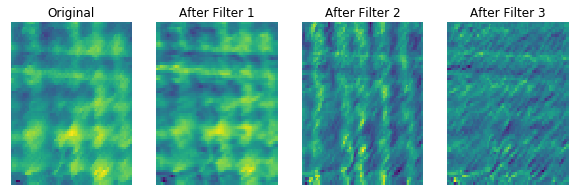

In [6]:
# colormap and sample
cmap='viridis'
# sample_idx = np.random.randint(0,len(X),1)[0]
sample_idx = 10

fig, axes = plt.subplots(1,4,figsize = (10,3))

viz_filtered_sample(X, sample_idx, np.identity(1), axes[0])
axes[0].set_title('Original')

weigths = get_filter(0,0)
viz_filtered_sample(X, sample_idx, weigths, axes[1])
axes[1].set_title('After Filter 1')

weigths = get_filter(0,1)
viz_filtered_sample(X, sample_idx, weigths, axes[2])
axes[2].set_title('After Filter 2')

weigths = get_filter(0,2)
viz_filtered_sample(X, sample_idx, weigths, axes[3])
axes[3].set_title('After Filter 3')

# timestamp = str(int(time.time()*1000000))[0:-1]
# plt.savefig('./figures/{0}_by_{0}_input_{1}_by_{1}_filter_{2}.png'.format(patch_size, 7, timestamp),
#            bbox_inches='tight', dpi=200)

## Visualizing layer outputs 

In [7]:
# modified from https://www.kaggle.com/amarjeet007/visualize-cnn-with-keras

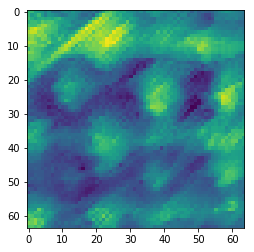

In [8]:
sample_idx = 156
sample = X[sample_idx]
plt.imshow(sample.reshape(sample.shape[0], sample.shape[1]), cmap='viridis')

In [9]:
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(sample.reshape(1,*sample.shape[:2],1))
 
def display_activation(activations, nrows, ncols, act_index, size=2.5): 
    activation = activations[act_index]
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*size,nrows*size))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(activation[0, :, :, i], cmap='viridis')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.subplots_adjust(hspace=0.02, wspace=-0.1)

In [10]:
### handling folders

layers_folder = './figures/layers/'
#check for model folder
if model_name not in os.listdir(layers_folder):
    os.mkdir(layers_folder + model_name)

model_folder = layers_folder + model_name + '/'

# create layer folder
sample_folder_name = f'X_{sample_idx}'

if sample_folder_name not in os.listdir(model_folder):
    os.mkdir(model_folder + sample_folder_name)

sample_folder = model_folder + sample_folder_name + '/'

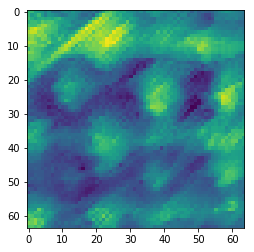

In [11]:
# save sample
plt.imshow(sample.reshape(sample.shape[0], sample.shape[1]))
#plt.savefig(sample_folder + 'sample.png', dpi=200, bbox_inches='tight')

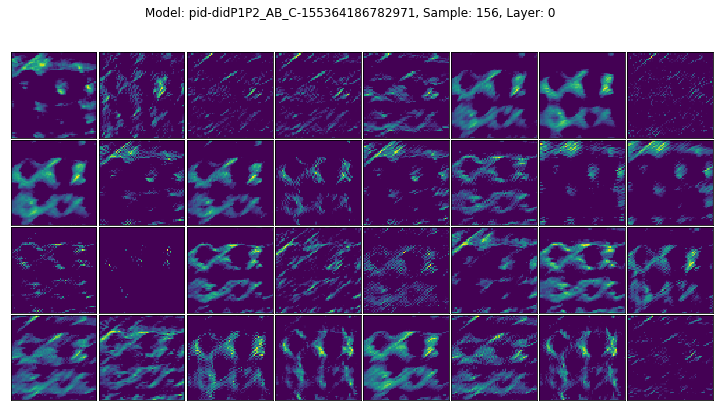

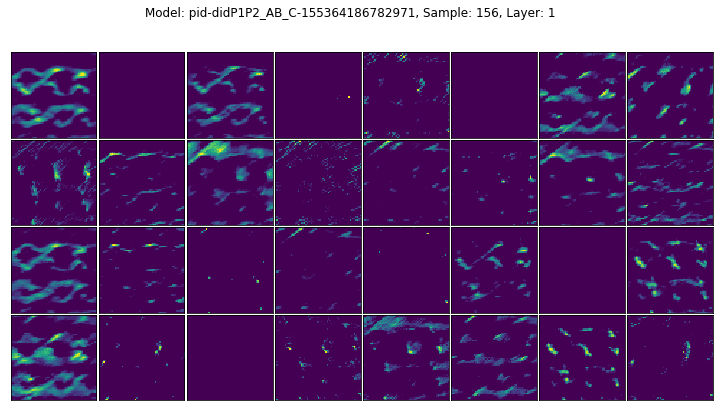

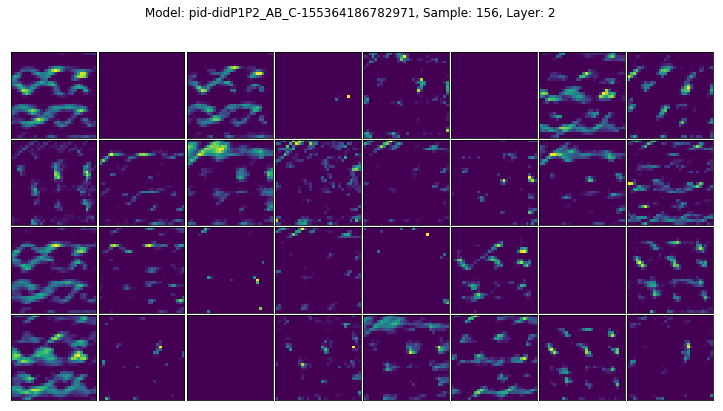

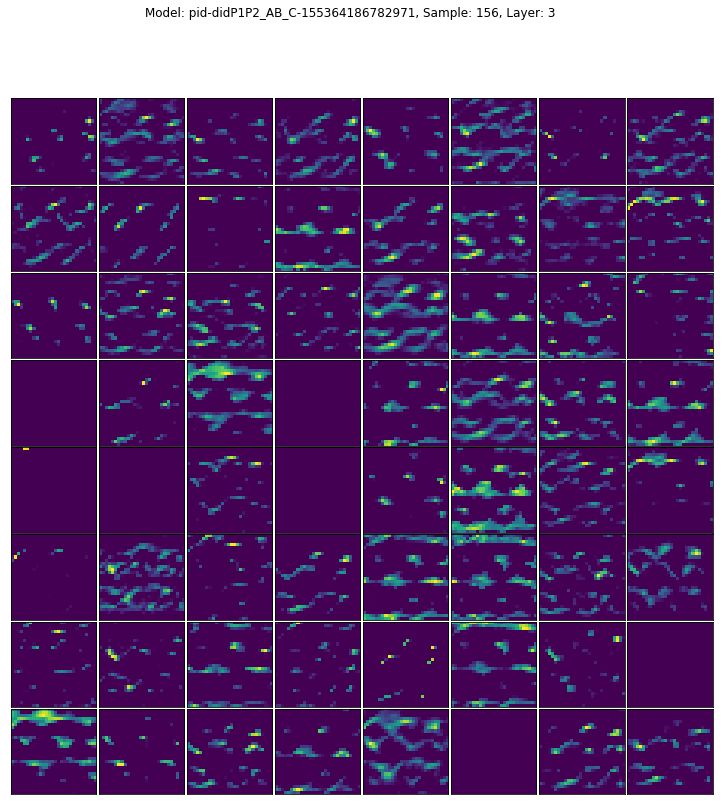

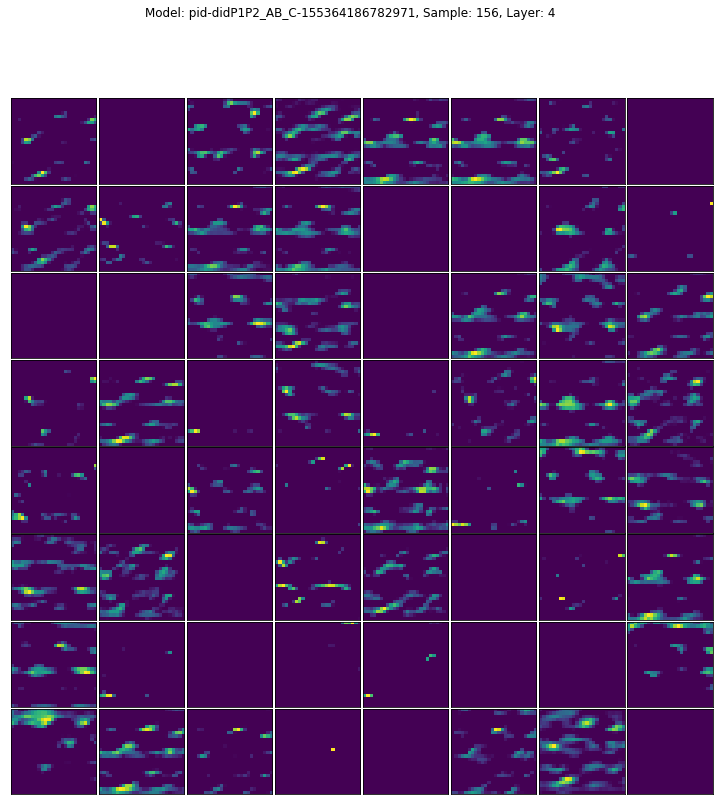

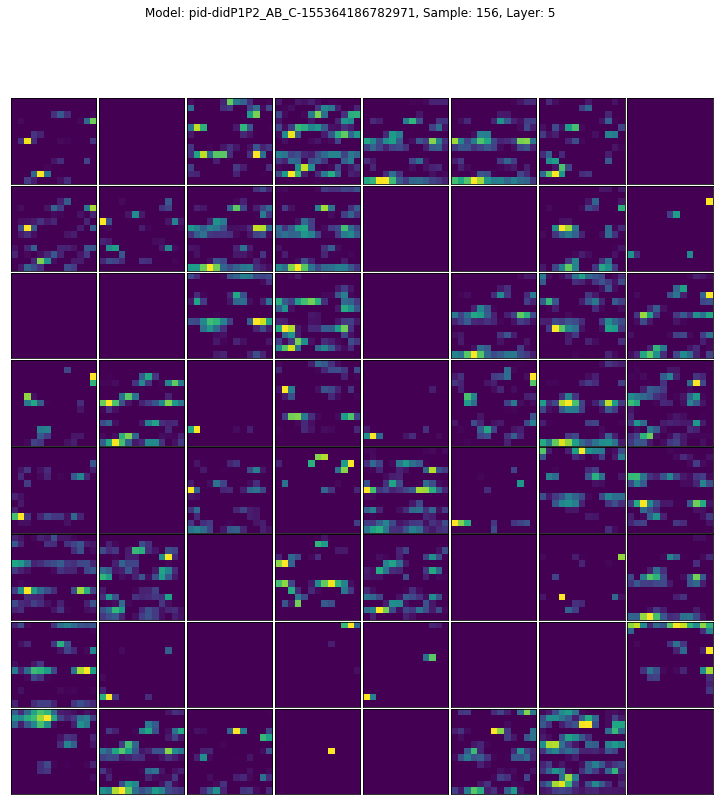

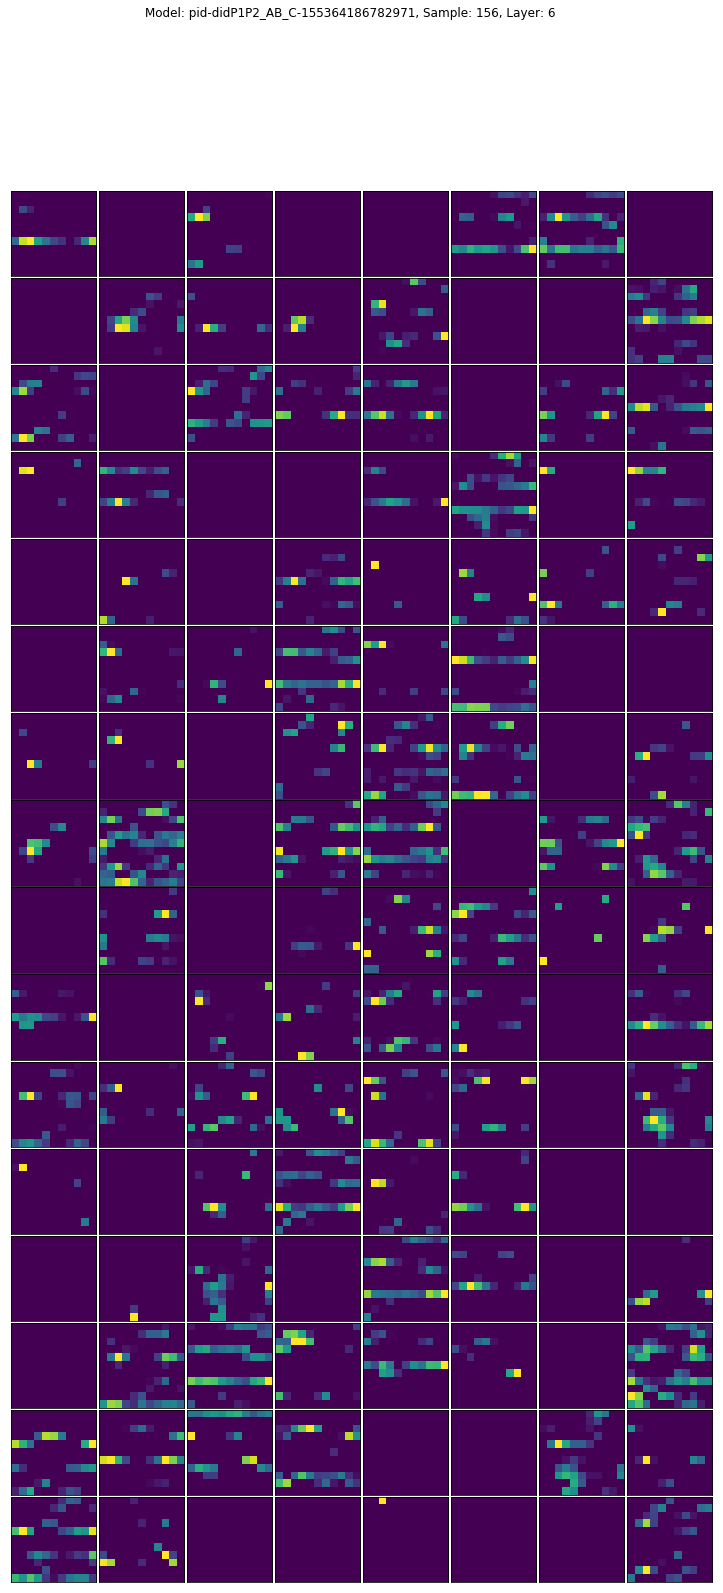

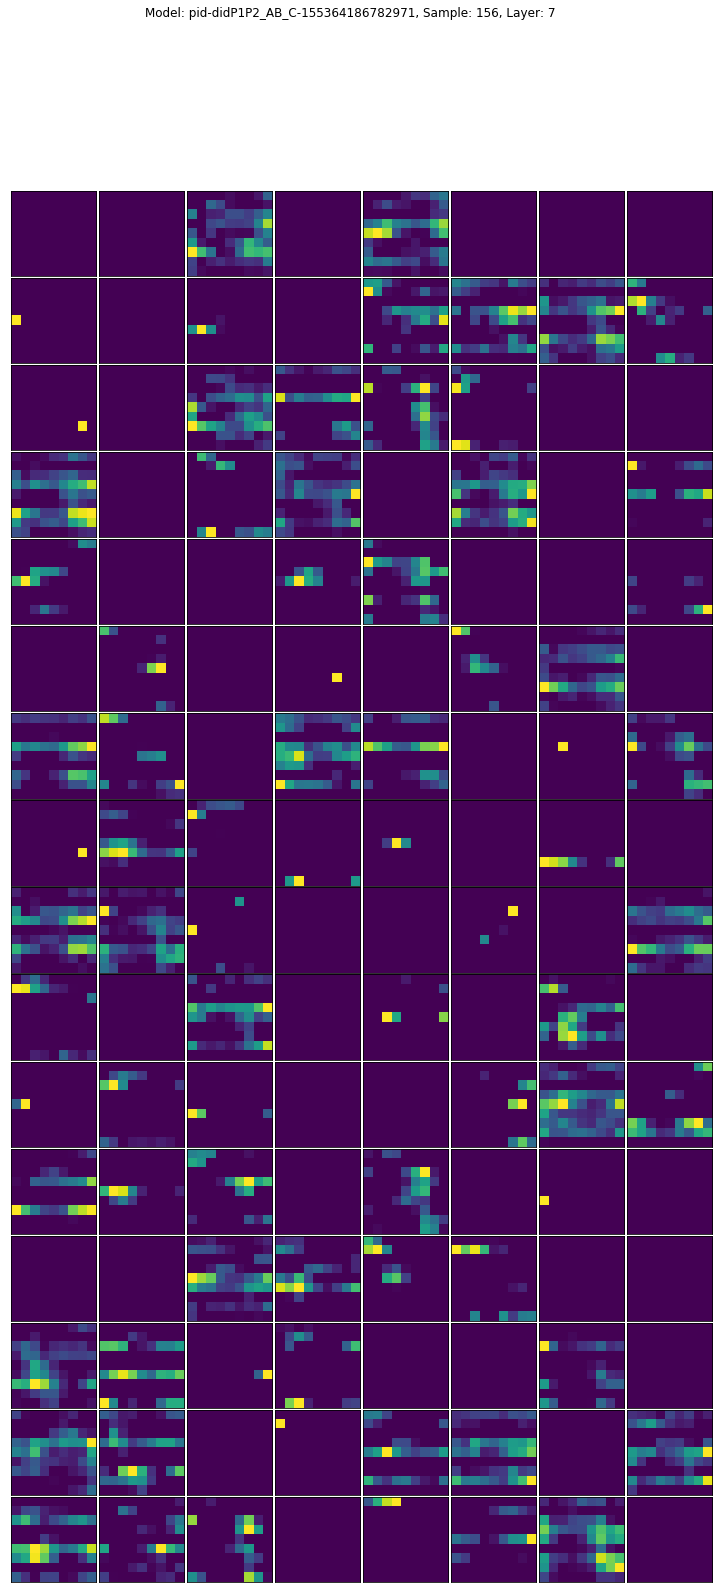

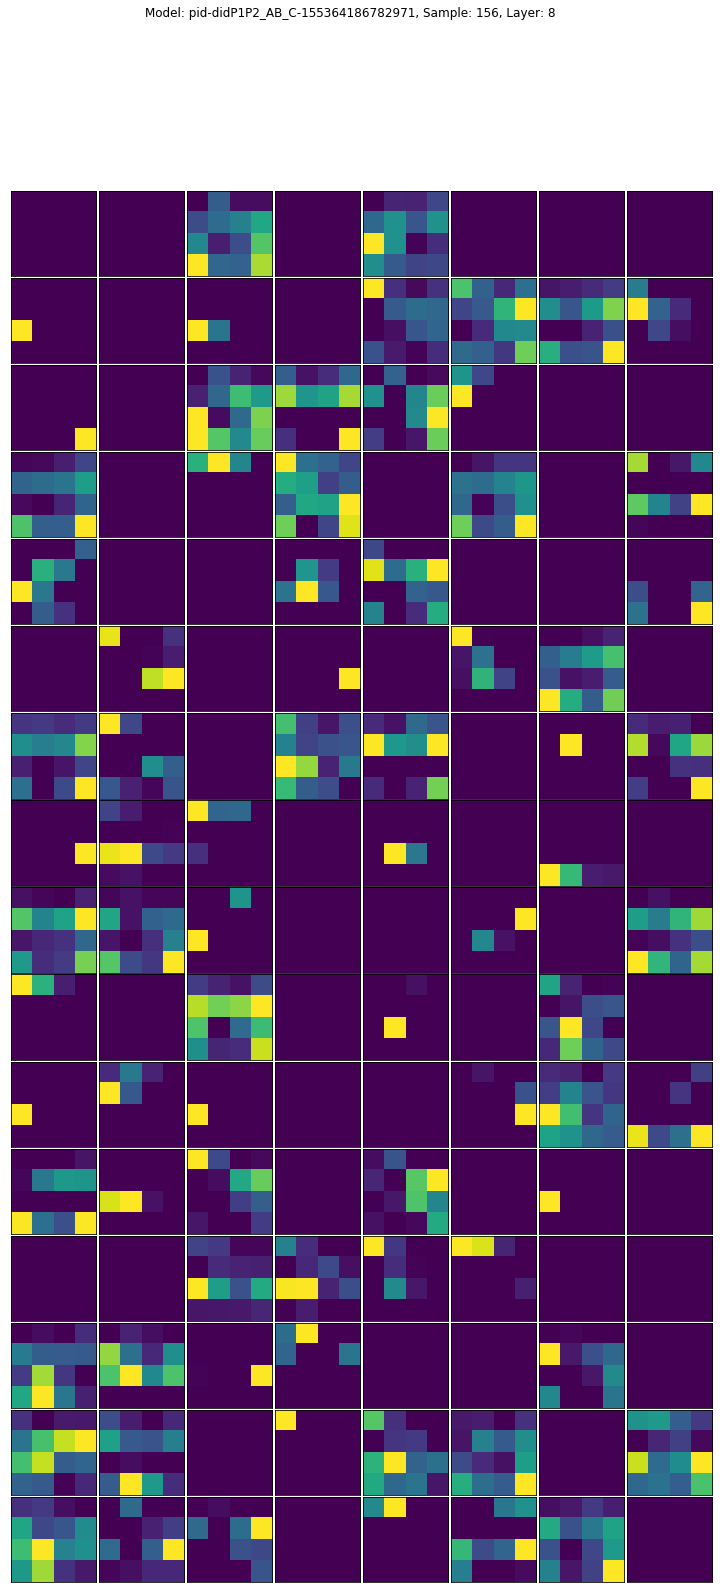

In [12]:
for i, layer in enumerate(model.layers[:9]):
    n_filters = layer.output_shape[-1]
    display_activation(activations,n_filters//8,8,i, size=1.6)
    plt.suptitle(f'Model: {model_name}, Sample: {sample_idx}, Layer: {i}')
    #plt.savefig(f'{sample_folder}/layer_{i}.png', dpi=200, bbox_inches='tight')

# Paintings 

In [13]:
from data_processing import data_to_array

In [14]:
train_test_samples = ['WL_M1_P1_A_Height.txt',
 'WL_M1_P1_B_Height.txt',
 'WL_M1_P2_A_Height.txt',
 'WL_M1_P2_B_Height.txt']

val_samples = ['WL_M1_P1_C_Height.txt',
 'WL_M1_P2_C_Height.txt']

samples = train_test_samples + val_samples

# files list
files = [data_folder + sn for sn in samples]

In [15]:
painting_arrays = [None]*len(files)
for i, f in enumerate(files):
    painting_arrays[i] = data_to_array(f)   

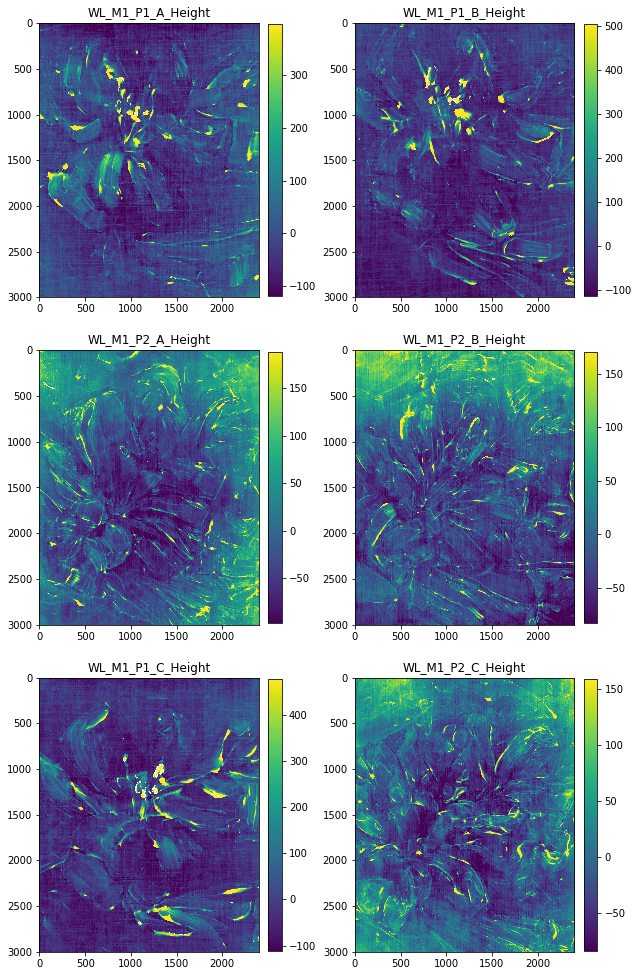

In [16]:
fig, axes = plt.subplots(3,2, figsize=(2*5,3*6))

for i, ax in enumerate(axes.flatten()):
    p = painting_arrays[i] - np.nanmean(painting_arrays[i])
    ptiles = np.nanpercentile(p.flatten(),[1,99])
    img = ax.imshow(p, vmin=ptiles[0], vmax=ptiles[1])
    plt.colorbar(img, ax=ax, fraction=0.056, pad=0.04)
    ax.set_title(samples[i].split('.')[0])
    
plt.subplots_adjust(wspace=0.3, hspace=0.01)

fig_name = 'P1P2_ABC_Height.png'
plt.savefig(f'./figures/samples/{fig_name}', dpi=200, bbox_inches='tight')

# Class prediction map

In [18]:
def plot_predictions(file, target, scalar, model, vmax=None, vmax_percentile=95):
    # get patch_size from model
    patch_size = model.layers[0].input_shape[1]
    # get data array and X
    data_array = data_to_array(file)
    X, y = processing_pipeline([file], patch_size, [target], shuffle=False, dropna=False) 
    # scale X
    X = scaler.transform(X.reshape(*X.shape,1))
    # get border pixels to crop
    cropx, cropy = [i%patch_size for i in data_array.shape]
    # crop data_array
    data_array = data_array[:-cropx,:-cropy]
    # get shape and reshape class array
    image_shape = np.array(data_array.shape)
    pred_shape = image_shape//patch_size
    
    # get classes
    classes = model.predict_classes(X, verbose=1)
    classes = classes.reshape(pred_shape[0], pred_shape[1])
    
    # upscale to match original resolution
    classes = np.kron(classes, np.ones((patch_size, patch_size)))
    
    # create masked arrays
    masked_arrs = {}
    for c in sorted(np.unique(classes)):
        masked_arrs[str(c)] = np.ma.masked_where(classes != c,data_array)
    
    # plot colormaps
    if vmax is None:
        vmax = np.nanpercentile(data_array.flatten(), vmax_percentile)
    fig = plt.figure()
    colormaps = ['Blues', 'Reds', 'Viridis']
    fig = plt.figure(figsize=(10,10))
    for i,key in enumerate(masked_arrs.keys()):
        plt.imshow(masked_arrs[key], cmap=colormaps[i],
                   vmax=vmax)
        
    # nans
    nans = np.isnan(np.mean(X,axis=(1,2,3))).reshape(pred_shape[0], pred_shape[1])
    nans = np.kron(~nans, np.ones((patch_size, patch_size)))
    plt.imshow(np.ma.masked_where(nans, data_array), cmap='binary',
                   vmax=5500)
    # title
    sample_name = file.split('/')[-1].split('.')[0]
    plt.title(f'Sample: {sample_name}')

In [19]:
data_folder = '/media/modwyer/1TB_HDD/Downloads/Research-Data/painter-id/Large_12cmX15cm_50umResolution_400Hz/'
#data_folder = '/home/marcio/Downloads/Research-Data/Large_12cmX15cm_50umResolution_400Hz/'

data_files = ['WL_M1_P1_C_Height.txt', 
             'WL_M1_P2_C_Height.txt']

files = [data_folder+f for f in data_files]
y_list = [0, 1]

1702/1702 [==============================] - 4s 2ms/step


<Figure size 432x288 with 0 Axes>

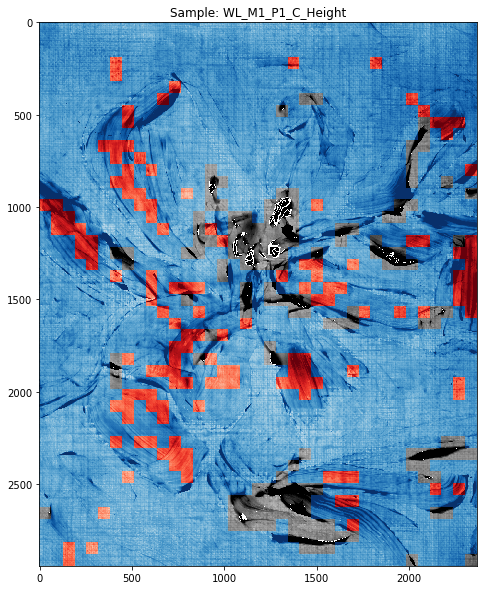

<Figure size 432x288 with 0 Axes>

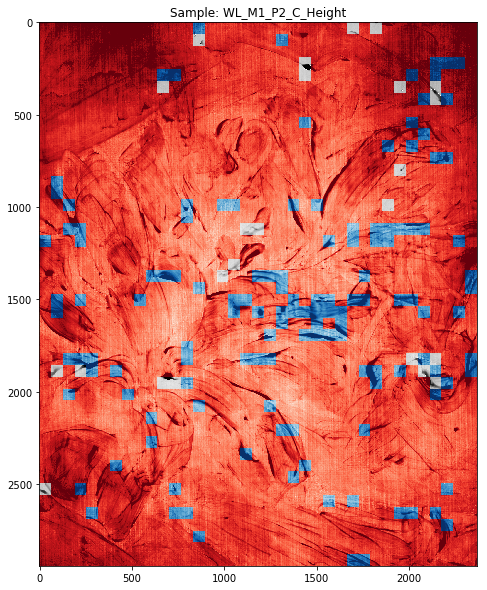

In [20]:
for f, target in zip(files, y_list):
    sample_name = f.split('/')[-1].split('.')[0]
    plot_predictions(f, y, scaler, model)
    #plt.savefig(f'./figures/class_prediction_maps/{sample_name}.png',
    #           dpi=200, bbox_inches = 'tight')

# Heatmaps
The steps to getting the probabilities for each patch:
- Import model and scaler. The scaler can be saved and loaded with the Scaler class in data_processing.
- Use model to find out patch size.
- Import sample and break it down into an X array of shape (n_samples, xlen, ylen, 1). This can be done with the processing pipeline.
- Apply the scaler to X.
- Use model on X to get probabilities. Now you have a probability for each patch.
- Reshape the array of probabilities to match input image and deal with trimming.
- Plot.

In [28]:
#data_folder = '/home/marcio/Downloads/Research-Data/Large_12cmX15cm_50umResolution_400Hz/'
data_folder = '/media/modwyer/1TB_HDD/Downloads/Research-Data/painter-id/Large_12cmX15cm_50umResolution_400Hz/'
data_files = ['WL_M1_P1_C_Height.txt']

# getting X and y
files = [data_folder+f for f in data_files]
y_list = [0]

patch_size = model.layers[0].input_shape[1]

In [20]:
# importing without dropping nans now so we can have the whole painting
X, y = processing_pipeline(files, patch_size, y_list, shuffle=False, dropna=False)
print(f"There are {len(y)} patches of shapes {X.shape[1:]}.")
# scaling
X = scaler.transform(X.reshape(*X.shape,1))

There are 1702 patches of shapes (64, 64).


In [21]:
# make predictions
# nan patches will have nan p
proba = model.predict_proba(X)

/home/modwyer/anaconda3/envs/up/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
/home/modwyer/anaconda3/envs/up/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


In [22]:
from data_processing import data_to_array

In [23]:
# reshape it to original image's shape
data_address = files[0]
data_array = data_to_array(data_address)

# get border pixels to crop
cropx, cropy = [i%patch_size for i in data_array.shape]

# crop data_array
data_array = data_array[:-cropx,:-cropy]

# get shape and reshape proba array
image_shape = np.array(data_array.shape)
proba_shape = image_shape//patch_size

p_1 = proba[:,y_list[0]].reshape(proba_shape[0], proba_shape[1])

In [24]:
# upscale to match original resolution
p_1 = np.kron(p_1, np.ones((patch_size, patch_size)))

In [25]:
import matplotlib.cm as cm

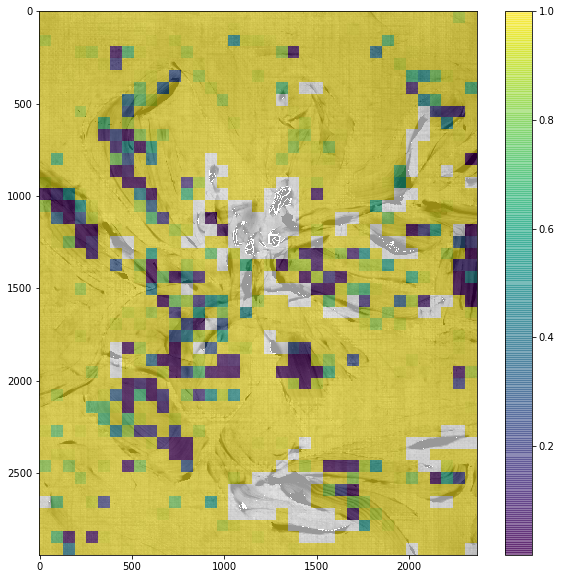

In [26]:
# display one on top of the other
fig = plt.figure(figsize=(10,10))

cmap = cm.get_cmap('viridis')
cmap.set_bad(color='white')

plt.imshow(data_array, cmap='binary',vmax=5500)
plt.imshow(p_1, alpha=0.6, cmap=cmap)
plt.colorbar()